## RNN with Pytorch
We will demonstrate RNN with a non-trivial example. The function we want to estimate has both an auto-regressive component and another predictor.  We will estimate this function using an RNN. This example serves to illustrate how RNN can be applied to prediction problems

In [90]:
import numpy as np
import datetime
from datetime import timedelta
start_time = datetime.datetime(18,11,5,12,32,23)
timestamps = [start_time + timedelta(days = i) for i in range(500)]

### Notation:
1. resp : The response we want to model
2. predictor2: Independent attribute for predicting the response (resp). Values for predictor2 are drawn from a $\mathbf{N}(0,1)$ distribution.
3. autoregressive component: The response also depends on the value at the previous time step.
4. noise: A small amount of noise, $\mathbf{N}(0,0.1)$, was added to the response

$$ resp(t) = resp(t-1) * 1.01 + 0.4* predictor2$$
Initial value of the response, resp(0) = 12344.44

The response could represent something we are interested in forecasting, say sales.


In [91]:
np.random.seed(1234)
sales_time_zero = 12344.44
predictor2 = np.random.normal(0, 1, 500)
resp = np.zeros(500, np.float64)

for i in range(500):
    if i == 0:
        resp[i] = sales_time_zero
    else:
        resp[i] = resp[(i-1)]* 1.01 + 0.4*predictor2[i] + np.random.normal(0, 0.1, 1)

In [92]:
SEQ_START = 0
SEQ_LENGTH = 4
SEQ_END = SEQ_START + SEQ_LENGTH
INPUT_SIZE = 2
HIDDEN_SIZE = 4
NUM_LAYERS = 1
OUTPUT_SIZE = 1
BATCH_SIZE = 1
def get_seq_data():
    global SEQ_START, SEQ_END, SEQ_LENGTH
    x_dc1 = resp[SEQ_START:SEQ_END]
    x_dc1 = x_dc1.reshape((x_dc1.shape[0], 1))
    x_dc2 = predictor2[SEQ_START:SEQ_END] 
    x_dc2 = x_dc2.reshape((x_dc2.shape[0],1))
    x_d = np.hstack((x_dc1, x_dc2))
    #x_d = x_d.reshape((SEQ_LENGTH, INPUT_SIZE, BATCH_SIZE))
    y_data = resp[(SEQ_START + 1):(SEQ_END + 1)]
    y_data = y_data.reshape((y_data.shape[0],1))
    SEQ_START = SEQ_START + 1
    SEQ_END = SEQ_START + SEQ_LENGTH
    return x_d, y_data


In [93]:
def reset_params():
    global SEQ_START, SEQ_END, SEQ_LENGTH, INPUT_SIZE, NUM_LAYERS, OUTPUT_SIZE, BATCH_SIZE
    SEQ_START = 0
    SEQ_LENGTH = 4
    SEQ_END = SEQ_START + SEQ_LENGTH
    INPUT_SIZE = 2
    HIDDEN_SIZE = 4
    NUM_LAYERS = 1
    OUTPUT_SIZE = 1
    BATCH_SIZE = 1
    
    return

### Implementation Notes:
Implementation borrowed mainly from pytorch documentation (https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html?highlight=rnn)


In [94]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)





In [95]:
from torch import optim
def train():
    n_epochs = 3
    losses = np.zeros(n_epochs) # For plotting
    n_sequences = 101
    rnn = RNN( INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
    hidden = rnn.initHidden()
    learning_rate = 0.01
    reset_params()
    optimizer = torch.optim.Adam(rnn.parameters(), lr= learning_rate)   # optimize all cnn parameters
    loss_func = nn.MSELoss()

    for epoch in range(n_epochs):
        print "Epoch: " + str(epoch)
        for iter in range(n_sequences):
       
            xd, yd = get_seq_data()
            inputs = Variable(torch.Tensor(xd))
            targets = Variable(torch.Tensor(yd))
            outs = []
            loss = None
            for i in range(SEQ_LENGTH):
                xdi = inputs[i]
                xdi = xdi.reshape((1, xdi.shape[0]))
                output, hidden = rnn(xdi, hidden)
                ## IMPORTANT step
                hidden = hidden.data
                outs.append(output)
        
        
        
            ts_output = torch.stack(outs, dim=1)
            ts_output = ts_output.view(SEQ_LENGTH, 1)
            loss = loss_func(ts_output, targets)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

        print "Loss: "  + str(loss.item())
        
        

## Note:
Training on the first 300 or so values. The trained model is used to forecast the remainder

In [96]:
SEQ_START

0

In [97]:
498/4

124

In [98]:
train()
TEST_SEQUENCES = 124
outs = []
acts = []
for iter in range(TEST_SEQUENCES):
       
    xd, yd = get_seq_data()
    inputs = Variable(torch.Tensor(xd))
    targets = Variable(torch.Tensor(yd))
    acts.extend(list(yd.ravel()))
   
    
    for i in range(SEQ_LENGTH):
        xdi = inputs[i]
        xdi = xdi.reshape((1, xdi.shape[0]))
        output, hidden = rnn(xdi, hidden)
        hidden = hidden.data
        pred = output.data.numpy()
        pred = pred[0]
        outs.append(pred)
        


Epoch: 0
Loss: 15998.9736328
Epoch: 1
Loss: 117031.046875
Epoch: 2
Loss: 1082592.375


## Performance
Plot of predicted versus actual is a straight line - so the model did a decent job

Text(0,0.5,'Predicted')

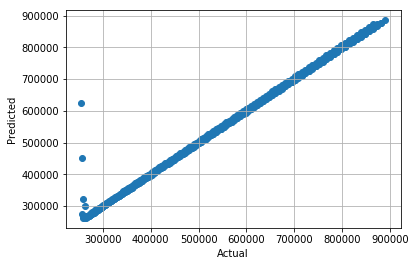

In [99]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(acts, outs)
plt.grid()
plt.xlabel("Actual")
plt.ylabel("Predicted")

In [100]:
from sklearn.metrics import r2_score
r2_score(acts, outs)

0.9882393677591368